In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
import csv
import pandas as pd
from sklearn.linear_model import LinearRegression
%matplotlib inline

# songs voted on piki

In [2]:
interactions_from_selected_users_df=pd.read_csv('data.csv')
len(interactions_from_selected_users_df)

353891

# songs imported from Spotify (top listens per user)

In [4]:
piki_spotify_imports = pd.read_csv("piki_user_songs.csv",engine='python') 
mkt_share=piki_spotify_imports.groupby('pop_decile')['pop_decile'].count()/piki_spotify_imports.count()[0] #.sort_values(ascending=False)
artists=[]
pop_deciles=[]
for index, song in piki_spotify_imports.iterrows():
    artists.append(song['artist'])
    pop_deciles.append(song['pop_decile'])

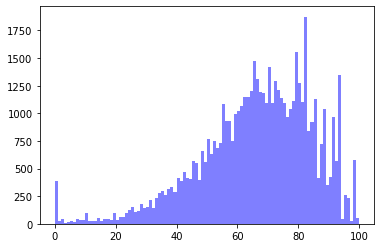

In [5]:
n, bins, patches = plt.hist(pop_deciles, 100, facecolor='blue', alpha=0.5)

# Empirical facts about people's tastes

# 1) Popular songs are liked more 
(for spotify popularity >60)

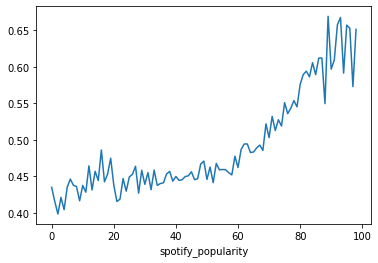

In [6]:
interactions_from_selected_users_df.groupby(['spotify_popularity']).mean()['liked'].plot()

# 2) Popularity of rated songs is normally distributed around 50

Spotify popularity 60 = 1,000,000 monthly listeners

Spotify popularity 50 = 300,000 monthly listeners

songs voted on piki are on average less popular than songs streamed on spotify

In [12]:
piki_spotify_imports = pd.read_csv("piki_user_songs.csv",engine='python') 
mkt_share=piki_spotify_imports.groupby('pop_decile')['pop_decile'].count()/piki_spotify_imports.count()[0] #.sort_values(ascending=False)
artists=[]
pop_deciles=[]
for index, song in piki_spotify_imports.iterrows():
    artists.append(song['artist'])
    pop_deciles.append(song['pop_decile'])

Text(0, 0.5, 'count')

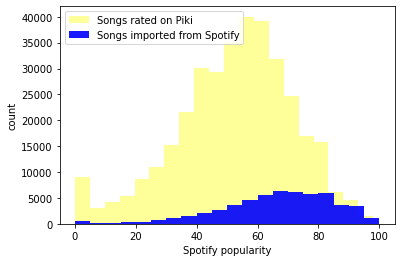

In [13]:
#interactions_from_selected_users_df.groupby(['spotify_popularity']).count()['liked'].plot()
plt.hist(interactions_from_selected_users_df['spotify_popularity'], 20, facecolor='yellow', alpha=0.4,label='Songs rated on Piki')
n, bins, patches = plt.hist(pop_deciles, 20, facecolor='blue', alpha=0.9,label='Songs imported from Spotify')
plt.legend()
plt.xlabel('Spotify popularity')
plt.ylabel('count')

# song quality distribution (% likes)

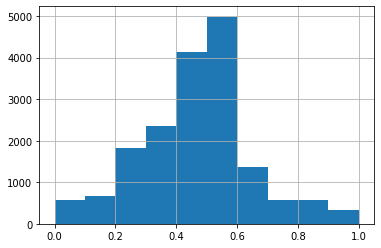

In [9]:
interactions_from_selected_users_df.groupby(['song_id']).mean()['liked'].sort_values().hist()

# user pikiness distribution (% likes)

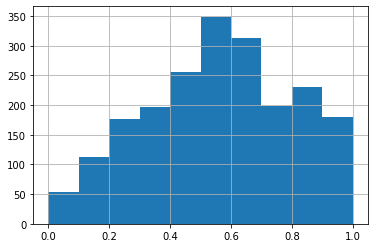

In [10]:
interactions_from_selected_users_df.groupby(['user_id']).mean()['liked'].sort_values().hist()

# Split into training and testing set

In [14]:
train_df, test_df = train_test_split(interactions_from_selected_users_df,
                                   stratify=interactions_from_selected_users_df['user_id'], 
                                   test_size=0.2)
print('# interactions on Train set: %d' % len(train_df))
print('# interactions on Test set: %d' % len(test_df))

# interactions on Train set: 283112
# interactions on Test set: 70779


In [15]:
# fill the predictions dataframe for the test set 
# then compute metrics for the entire test set
class GlobalModelEvaluator:

    def __init__(self, test_df):
        self.test_df = test_df
        self.predictions_df = pd.DataFrame(columns = ['user_id','song_id','liked'],dtype='int') 
        
    def evaluate_model_for_user(self, model, user_id):
        # get list of songs to be classified for this user
        song_list=self.test_df[self.test_df['user_id']==user_id].set_index('song_id') #.sort_index()
        # ask the model to classify
        user_recs_df = model.classify_items(user_id,song_list) #.sort_index()
        user_recs_df=user_recs_df.reset_index(drop=False)
        user_recs_df['user_id']=user_id
        # append the classification to the predictions dataframe
        self.predictions_df=self.predictions_df.append(user_recs_df,ignore_index = True)
        return user_recs_df

    def evaluate_model(self, model):
        people_metrics = []
        # loop through all users and classify test songs
        for user_id in self.test_df.groupby('user_id').mean().index:
            person_metrics = self.evaluate_model_for_user(model, user_id)  
         
        self.test_df=self.test_df.set_index(['user_id', 'song_id']).sort_index()
        self.predictions_df=self.predictions_df.set_index(['user_id', 'song_id']).sort_index()
        # compute global metrics
        global_accuracy=metrics.accuracy_score(self.test_df['liked'],self.predictions_df['liked'])
        global_kappa=metrics.cohen_kappa_score(self.test_df['liked'],self.predictions_df['liked'])
        global_pop_bias=self.test_df['spotify_popularity'][self.predictions_df['liked']==1].mean()-self.test_df['spotify_popularity'][self.test_df['liked']==1].mean()
        return global_accuracy,global_kappa,global_pop_bias,self.test_df['liked'],self.predictions_df['liked'] #,global_pop_bias,global_metrics, detailed_results_df

global_model_evaluator = GlobalModelEvaluator(test_df)

# Non - personalized algos

In [16]:
class PopularityThresholdRecommender:
    # given a Spotify popularity threshold, all songs above this threshold are classified as a "like"
    MODEL_NAME = 'PopularityThreshold'
    
    def __init__(self, test_df, threshold):
        self.test_df = test_df
        self.threshold= threshold
        
    def get_model_name(self):
        return self.MODEL_NAME

    def classify_items(self, user_id, song_popularity):
        data=1*(song_popularity>self.threshold)['spotify_popularity'].values
        index=song_popularity.index
        recommendations_df = pd.DataFrame(data, index=index,columns=['liked'])
        return recommendations_df 

In [17]:
# loop through various Spotify popularity threshold
for i in (40,45,50,55,60,65,70,75):
    pr=PopularityThresholdRecommender(test_df,i)
    global_model_evaluator = GlobalModelEvaluator(test_df)
    a,b,c,d,e=global_model_evaluator.evaluate_model(pr)
    print(i,a,b,c)

40 0.5041890956357111 0.031103641671495263 6.73323335242187
45 0.5129346275025078 0.04050058598063533 9.105337639520734
50 0.5225985108577403 0.0510377546908507 11.756506553967263
55 0.5307082609248506 0.058178556571947815 14.631238125961282
60 0.5395244352138346 0.06679915869035324 17.84781762818954
65 0.5431837126831405 0.0652156372508218 21.632528091441905
70 0.5421382048347674 0.056093870460889206 25.283378603662193
75 0.5389169103830233 0.044029110954683426 28.877811470752313


Conclusion: the higher thresholds have higher accuracy and kappa, but there is a strong popularity bias

In [18]:
class RandomPikinessRecommender:
    # for each user, compute the pikiness (% liked on the training set for that user)
    # randomly classify this percentage of test items as liked
    MODEL_NAME = 'RandomPikiness'
    
    def __init__(self, test_df):
        self.test_df = test_df
        
    def get_model_name(self):
        return self.MODEL_NAME

    def classify_items(self, user_id, song_popularity):
        pikiness=train_df[(train_df['user_id']==user_id)].set_index('song_id')['liked'].mean()
        N=len(song_popularity)
        recommendations_df = pd.DataFrame(1*(np.random.rand(N) > 1-pikiness), index=song_popularity.index,columns=['liked'])
        return recommendations_df 

In [19]:
global_model_evaluator = GlobalModelEvaluator(test_df)
rpr=RandomPikinessRecommender(test_df)
a,b,c,d,e=global_model_evaluator.evaluate_model(rpr)
print(a)
print(b)
print(c)

0.6616227977224883
0.3219050784439377
-1.3946151268960492


Conclusion: although this recommender is random, it is personalized based on the pikiness of the user, so accuracy and cohen kappa is higher and there is no popularity bias

In [21]:
class PopularityPikinessRecommender:
    # for each user, compute the pikiness (% liked on the training set for that user)
    # we sort songs by Spotify popularity
    # and classify the top pikiness percentage of test items as liked
    MODEL_NAME = 'PopularityPikiness'
    
    def __init__(self, test_df):
        self.test_df = test_df
        
    def get_model_name(self):
        return self.MODEL_NAME

    def classify_items(self, user_id, song_popularity):
        pikiness=1-train_df[(train_df['user_id']==user_id)].set_index('song_id')['liked'].mean()
        threshold=song_popularity['spotify_popularity'].quantile(pikiness)
        # set a popularity threshold where we only pick a quantile sorted by spotify popularity
        recommendations_df = pd.DataFrame(1*(song_popularity>threshold)['spotify_popularity'].values, index=song_popularity.index,columns=['liked'])
        return recommendations_df 

In [22]:
global_model_evaluator = GlobalModelEvaluator(test_df)
ppr=PopularityPikinessRecommender(test_df.iloc)
a,b,c,d,e=global_model_evaluator.evaluate_model(ppr)
print(a)
print(b)
print(c)

0.683055708614137
0.3641713158845824
9.299222081636607


Conclusion: Sorting songs by Spotify popularity and classifying based on user pikiness improves over random, but popularity bias is significant

In [ ]:
def ThompsonRecommender:
    # for each user, compute the pikiness (% liked on the training set for that user)
    # we sort songs by Spotify popularity
    # and classify the top pikiness percentage of test items as liked
    MODEL_NAME = 'PopularityPikiness'
    
    def __init__(self, test_df):
        self.test_df = test_df
        
    def get_model_name(self):
        return self.MODEL_NAME

    def classify_items(self, user_id, song_popularity):
        pikiness=1-train_df[(train_df['user_id']==user_id)].set_index('song_id')['liked'].mean()
        threshold=song_popularity['spotify_popularity'].quantile(pikiness)
        # set a popularity threshold where we only pick a quantile sorted by spotify popularity
        recommendations_df = pd.DataFrame(1*(song_popularity>threshold)['spotify_popularity'].values, index=song_popularity.index,columns=['liked'])
        return recommendations_df 

# Personalized algos

In [24]:
def get_rater_accuracy(user1,user2):
    # given two users find the % agreement
    idx1=train_df[(train_df['user_id']==user1)].set_index('song_id').index
    idx2=train_df[(train_df['user_id']==user2)].set_index('song_id').index
    songs_in_common=idx1.intersection(idx2)
    num_songs_in_common=len(songs_in_common)
    rates1=train_df[(train_df['user_id']==user1)].set_index('song_id').loc[songs_in_common]['liked']
    rates2=train_df[(train_df['user_id']==user2)].set_index('song_id').loc[songs_in_common]['liked']
    #kappa=metrics.cohen_kappa_score(rates1,rates2)
    if len(songs_in_common)>1:
        accuracy=metrics.accuracy_score(rates1,rates2)
    else:
        accuracy=0
    return accuracy #,kappa,num_songs_in_common

In [25]:
user1=3728954
user2=3733458
get_rater_accuracy(user1,user2)

0.8571428571428571

In [26]:
user1=3733458
user2=3729941
get_rater_accuracy(user1,user2)

0.3333333333333333

In [27]:
def get_sentiment_score(user_id,song_id):
    sentiment=0
    # all the people who have rated this song
    potential_recommenders=train_df[(train_df['song_id']==song_id)]['user_id'].values
    for user in potential_recommenders:
        a=get_rater_accuracy(user_id,user)
        rater_contribution=(train_df[(train_df['user_id']==user) & (train_df['song_id']==song_id)]['liked']*2-1).iloc[0]
        sentiment=sentiment+a*rater_contribution
    return sentiment

In [28]:
get_sentiment_score(3733458,4225342)

-0.33333333333333337

In [29]:
class UserMatcher:
    
    MODEL_NAME = 'UserMatcher'
    
    def __init__(self, test_df):
        self.test_df = test_df
        
    def get_model_name(self):
        return self.MODEL_NAME

    def classify_items(self, user_id, song_popularity):
        pikiness=1-train_df[(train_df['user_id']==user_id)].set_index('song_id')['liked'].mean()
        #print(pikiness)
        threshold=song_popularity['spotify_popularity'].quantile(pikiness)
        # set a popularity threshold where we only pick a quantile sorted by spotify popularity
        
        user_songs=song_popularity.index
        recommendations_df = pd.DataFrame(index=user_songs,columns=['score','liked'],dtype='float')
        for song_id in user_songs:
            senti=get_sentiment_score(user_id,song_id)
            recommendations_df['score'].loc[song_id]=senti
        recommendations_df['score']=recommendations_df['score']
        threshold=recommendations_df['score'].quantile(pikiness)
        #print(threshold)
        #print(recommendations_df['score'])
        recommendations_df['liked']=1*(recommendations_df['score']>threshold)
        return recommendations_df['liked']

In [30]:
global_model_evaluator = GlobalModelEvaluator(test_df)
um=UserMatcher(test_df)
a,b,c,d,e=global_model_evaluator.evaluate_model(um)
print(a)
print(b)
print(c)

0.6810494638240155
0.36058762961454816
1.403870117177135


Conclusion

In [148]:
class KNNRecommender:
    
    MODEL_NAME = 'KNN'
    
    def __init__(self, test_df, k):
        self.test_df = test_df
        self.k= k
        
    def get_model_name(self):
        return self.MODEL_NAME

    def classify_items(self, user_id, song_popularity):
        my_song_raters=train_df[train_df['song_id'].isin(train_df[train_df['user_id'].isin([user_id])]['song_id'])]
        num_rates=my_song_raters.groupby('user_id').count().sort_values('liked')['liked']
        match_rates=my_song_raters.groupby('user_id').mean().sort_values('liked')['liked']
        my_top_k_matches=match_rates[num_rates>2].sort_values(ascending=False)[0:self.k].index
        their_avg_rates=train_df[train_df['user_id'].isin(my_top_k_matches)].groupby('song_id').mean().sort_values('liked',ascending=False)['liked']
        recommended_songs=their_avg_rates[their_avg_rates>.5].index
        songs_to_classify=song_popularity
        ones=songs_to_classify[songs_to_classify.index.isin(recommended_songs)] 
        ones.values[:]=1
        zeros=songs_to_classify[~songs_to_classify.index.isin(recommended_songs)] 
        zeros.values[:]=0
        recommendations_df=zeros.append(ones)
        return recommendations_df 

In [149]:
knn=KNNRecommender(test_df,30)

In [150]:
accuracy,kappa,pop_bias,global_metrics,people_metrics=model_evaluator.evaluate_model(knn)

In [151]:
global_metrics

{'modelName': 'KNN',
 'accuracy': 0.5132562059847782,
 'kappa': 0.008954520889905173,
 'pop_bias': -0.9538550750369177}

In [31]:
kappas=[]
accuracies=[]
pop_biases=[]
x_axis=(10,20,30,40,50,60,70,80)
for i in x_axis:
    pop_threshold_model=PopularityThresholdRecommender(test_df,i)
    accuracy,kappa,pop_bias,global_metrics,people_metrics=model_evaluator.evaluate_model(pop_threshold_model)
    kappas.append(kappa)
    accuracies.append(accuracy)
    pop_biases.append(pop_bias)

/usr/local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:620: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)


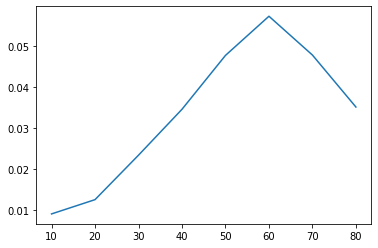

In [32]:
plt.plot(x_axis,kappas,label='pop_algo')

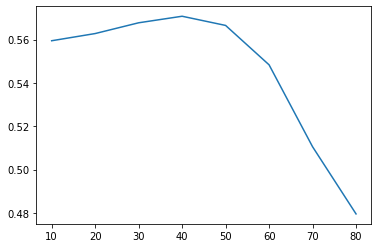

In [33]:
plt.plot(x_axis,accuracies,label='pop_algo')

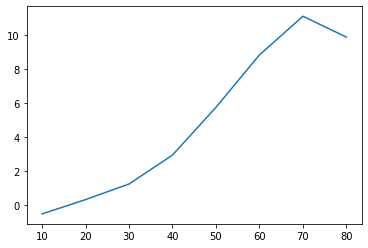

In [34]:
plt.plot(x_axis,pop_biases,label='pop_algo')

In [35]:
class PikiPopularityThresholdRecommender:
    
    MODEL_NAME = 'PikiPopularityThreshold'
    
    
    def __init__(self, test_df, train_df,threshold):
        self.test_df = test_df
        self.train_df = train_df
        self.threshold= threshold
        self.songs_by_piki_popularity=train_df.groupby('song_id')['liked'].mean()
        
    def get_model_name(self):
        return self.MODEL_NAME
     
    def classify_items(self, user_id, song_popularity):
        
        recommendations_df = 0*song_popularity
        for ind in recommendations_df.index: 
            try:
                if self.songs_by_piki_popularity[ind]>self.threshold:
                    recommendations_df[ind]=1
                else:
                    recommendations_df[ind]=0   
            except:
                recommendations_df[ind]=0   
        return recommendations_df 



In [36]:
kappas=[]
accuracies=[]
pop_biases=[]
x_axis=(.10,.20,.30,.40,.50,.60,.70,.80,.90)
for i in x_axis:
    piki_threshold_model=PikiPopularityThresholdRecommender(test_df,train_df,i)
    accuracy,kappa,pop_bias,global_metrics,people_metrics=model_evaluator.evaluate_model(piki_threshold_model)
    kappas.append(kappa)
    accuracies.append(accuracy)
    pop_biases.append(pop_bias)
    

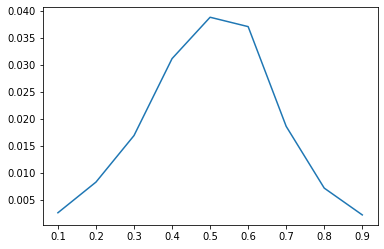

In [37]:
plt.plot(x_axis,kappas,label='piki_algo')

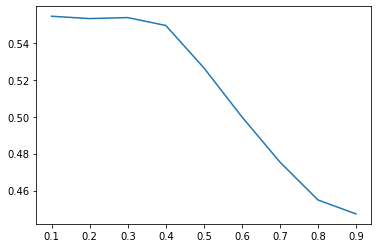

In [38]:
plt.plot(x_axis,accuracies,label='piki_algo')

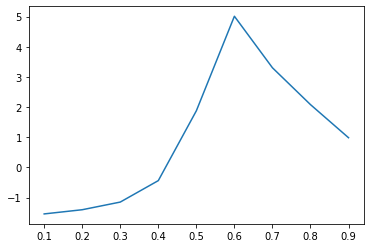

In [39]:
plt.plot(x_axis,pop_biases,label='piki_algo')

# SVM

In [414]:
from scipy.sparse import coo_matrix
# map each artist and user to a unique numeric value
train_df['user_id'] = train_df['user_id'].astype("category")
train_df['song_id'] = train_df['song_id'].astype("category")

# create a sparse matrix of all the artist/user/play triples
plays = coo_matrix((train_df['liked'].astype(float), 
                   (train_df['song_id'].cat.codes, 
                    train_df['user_id'].cat.codes)))
plays

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


<17355x2065 sparse matrix of type '<class 'numpy.float64'>'
	with 283112 stored elements in COOrdinate format>